In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('corona.csv')
df.tail()

,datetime,case,deaths
66,3/6/2020,102050,3494
67,3/7/2020,106099,3599
68,3/8/2020,109991,3827
69,3/9/2020,114381,4025
70,3/10/2020,118947,4296


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  71 non-null     object
 1   case      71 non-null     int64 
 2   deaths    71 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ KB


In [4]:
df['datetime']=pd.to_datetime(df['datetime'], format='%m/%d/%Y')

In [5]:
df.set_index('datetime', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2019-12-31 to 2020-03-10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   case    71 non-null     int64
 1   deaths  71 non-null     int64
dtypes: int64(2)
memory usage: 1.7 KB


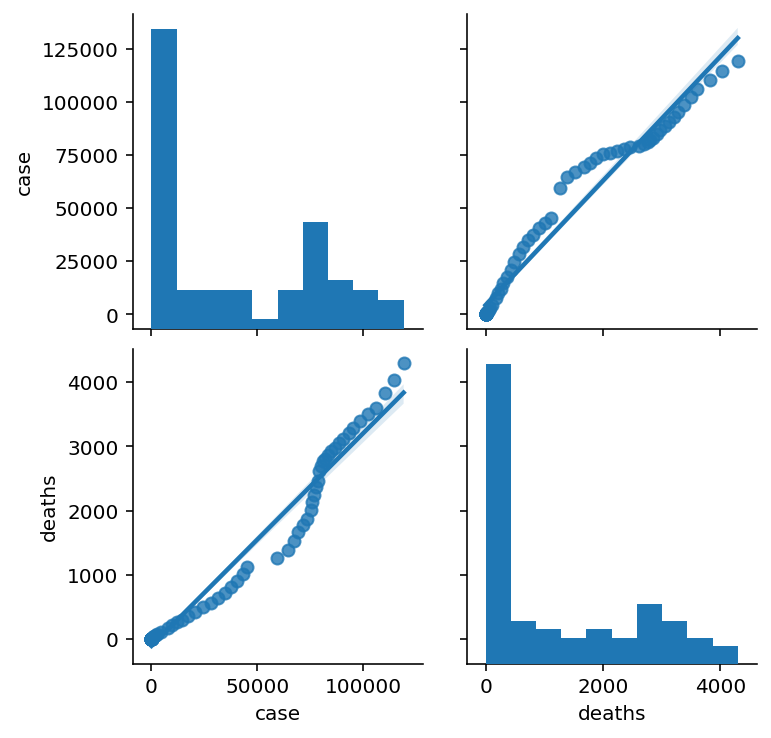

In [7]:
sns.pairplot(df, kind='reg')

In [8]:
diff = df.diff().fillna(0).astype('int')
diff.at['2019-12-31', ['case']] = 41

In [9]:
diff=diff[['case']]
diff

,case
datetime,
2019-12-31,41
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
...,...
2020-03-06,3625
2020-03-07,4049
2020-03-08,3892


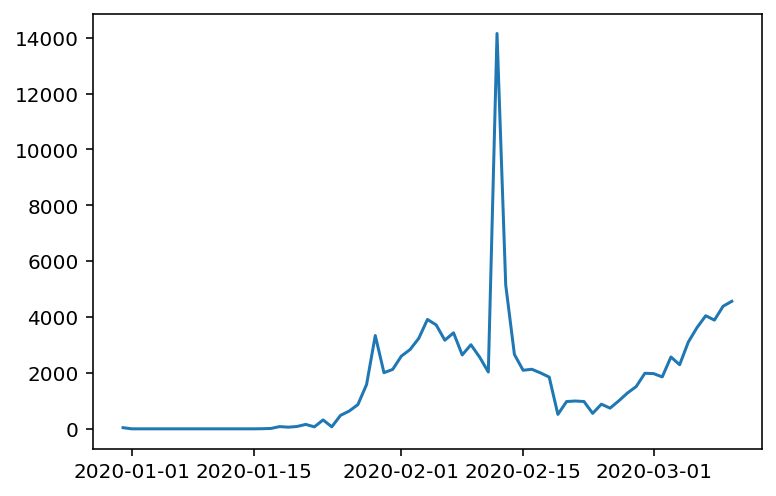

In [10]:
plt.plot(diff)

# Unit-root test

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

In [12]:
result = adfuller(df.deaths.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') #no unit-root
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 5.019839734991573
p-value: 1.0
Critial Values:
   1%, -3.548493559596539
Critial Values:
   5%, -2.912836594776334
Critial Values:
   10%, -2.594129155766944


In [13]:
train_len =int(df.shape[0]*0.8)
test_len = int(df.shape[0]*0.2)
print(f'train size: {train_len}')
print(f'test_size: {test_len}')

train size: 56
test_size: 14


In [14]:
train, test = diff[1:train_len], diff[train_len:] #0.8 train_test_split

In [15]:
train

,case
datetime,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-07,0
2020-01-08,0
2020-01-09,0


In [16]:
test

,case
datetime,
2020-02-25,741
2020-02-26,1001
2020-02-27,1283
2020-02-28,1512
2020-02-29,1989
2020-03-01,1977
2020-03-02,1859
2020-03-03,2572
2020-03-04,2295


## modeling

In [17]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
diff = diff.astype('float32') #fix some bugs

In [19]:
algo =[
    [AR(diff), 'AutoRegression'], 
    [ARMA(diff, order=(0, 1, 2)), 'ARMA'], 
    [SARIMAX(diff, order=(1, 2, 3), seasonal_order=(1, 1, 1, 12)), 'SARIMAX'], 
#     [VAR(diff), 'VAR']
#     [VARMAX(diff, order=(1, 1)), 'VARMAX'], 
    [SimpleExpSmoothing(diff), 'SimpleExpSmoothing'], 
    [ExponentialSmoothing(diff), 'ExponentialSmoothing']
]
for i in algo:
    model = i[0]
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train)+len(test), end=len(train)+len(test)+90)
    predictions[predictions < 0] = 0
    print(f'modelName: {i[1]}')
    print(predictions)
    print('-'*100)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:

modelName: AutoRegression
2020-03-10    3666.244187
2020-03-11    3904.177331
2020-03-12    3754.734029
2020-03-13    3720.872492
2020-03-14    3635.442733
                 ...     
2020-06-04    2294.535074
2020-06-05    2294.541012
2020-06-06    2294.545813
2020-06-07    2294.549589
2020-06-08    2294.552472
Freq: D, Length: 91, dtype: float64
----------------------------------------------------------------------------------------------------
modelName: ARMA
2020-03-10    2597.327012
2020-03-11    2549.188952
2020-03-12    1680.706626
2020-03-13    1680.706626
2020-03-14    1680.706626
                 ...     
2020-06-04    1680.706626
2020-06-05    1680.706626
2020-06-06    1680.706626
2020-06-07    1680.706626
2020-06-08    1680.706626
Freq: D, Length: 91, dtype: float64
----------------------------------------------------------------------------------------------------
modelName: SARIMAX
2020-03-10     3581.661214
2020-03-11     4208.712287
2020-03-12     4080.873155
2020-03-13  

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


## best model

In [20]:
model = SARIMAX(diff, order=(1, 2, 3), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train)+len(test), end=len(train)+len(test)+365)
predictions[predictions < 0] = 0

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
predictions

2020-03-10      3581.661214
2020-03-11      4208.712287
2020-03-12      4080.873155
2020-03-13      3954.320692
2020-03-14      3735.115837
                  ...      
2021-03-06    163241.669788
2021-03-07    164006.329314
2021-03-08    164730.250568
2021-03-09    165359.604529
2021-03-10    166235.944653
Freq: D, Length: 366, dtype: float64

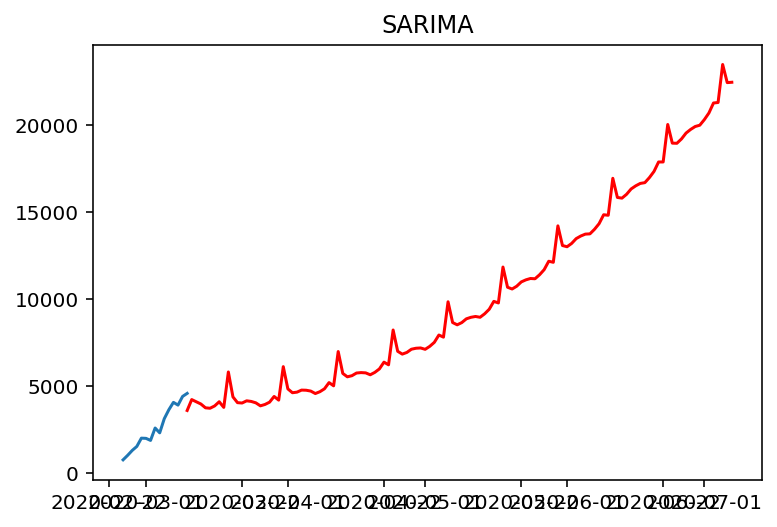

In [22]:
plt.plot(test)
plt.plot(predictions[:120], color='red')
plt.title('SARIMA')
plt.show()

## ploting

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:

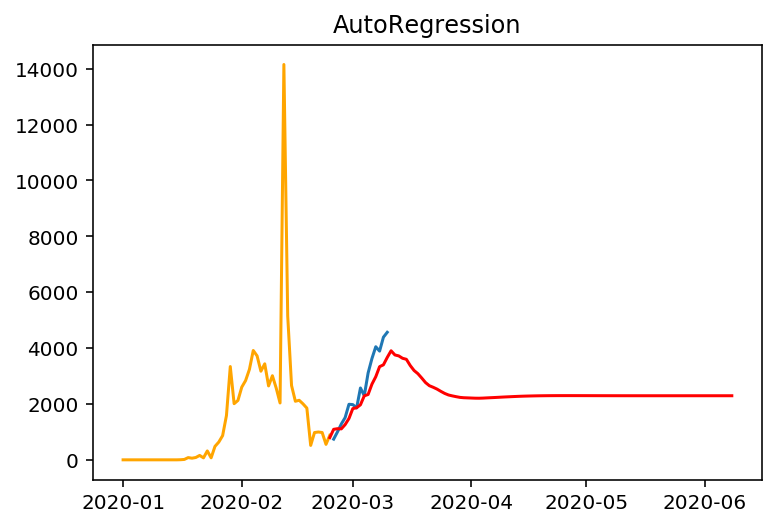

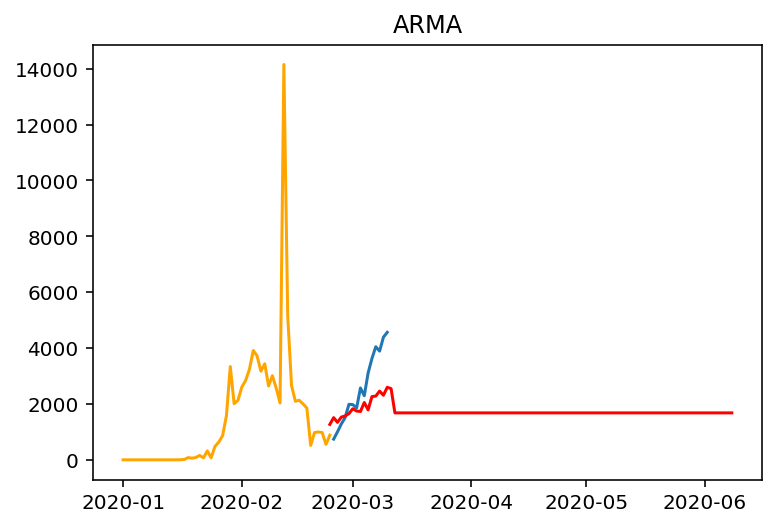

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


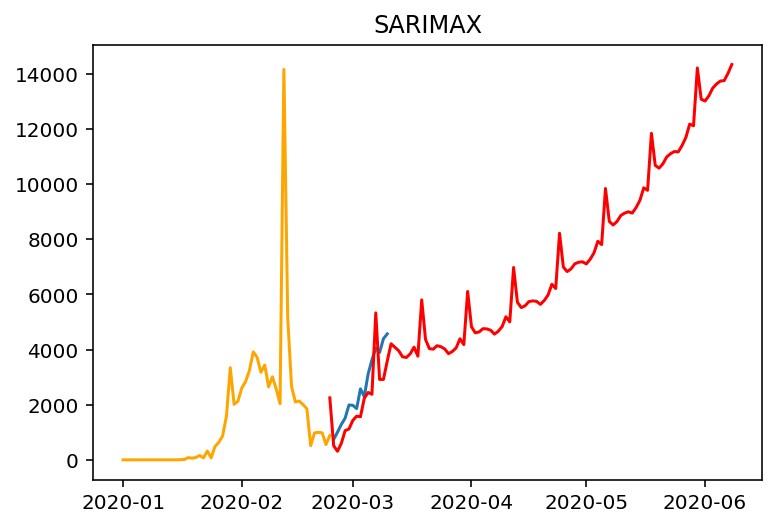

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


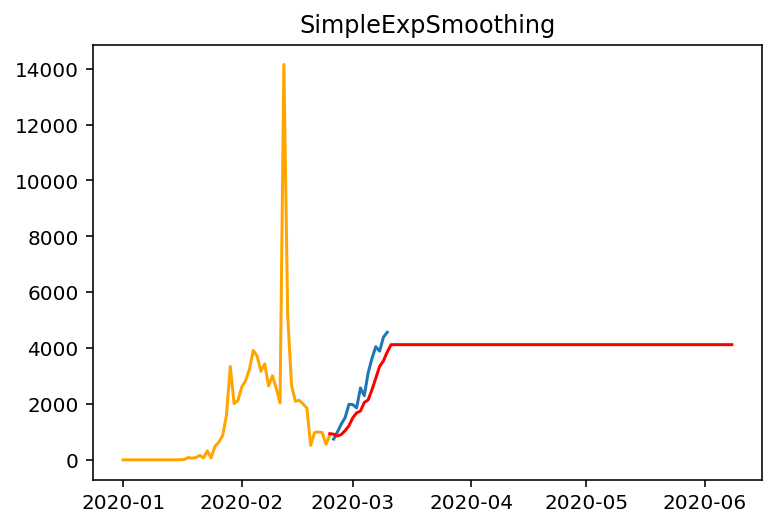

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


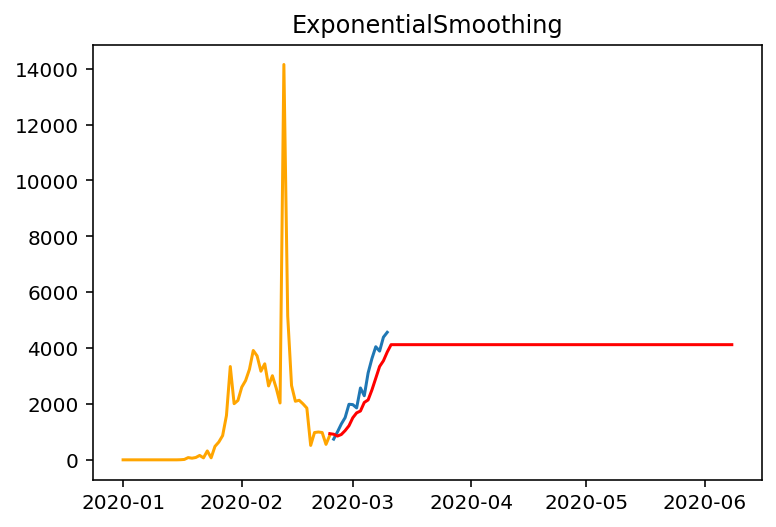

In [23]:
algo =[
    [AR(diff), 'AutoRegression'], 
    [ARMA(diff, order=(0, 1)), 'ARMA'], 
    [SARIMAX(diff, order=(1, 2, 3), seasonal_order=(1, 1, 1, 12)), 'SARIMAX'], 
#     [VAR(df), 'VAR']
#     [VARMAX(diff, order=(2, 1)), 'VARMAX'], 
    [SimpleExpSmoothing(diff), 'SimpleExpSmoothing'], 
    [ExponentialSmoothing(diff), 'ExponentialSmoothing']
]
for i in algo:
    model = i[0]
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)+90)
    predictions[predictions < 0] = 0
    plt.plot(train, color='orange')
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.title(i[1])
    plt.show()

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:

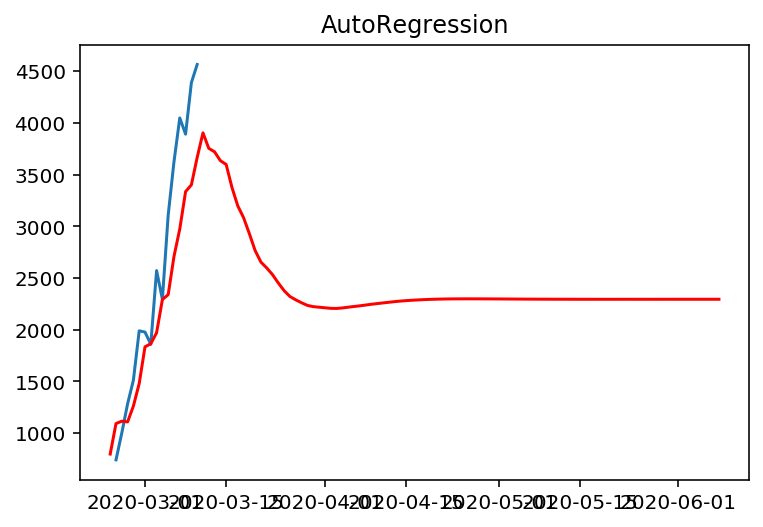

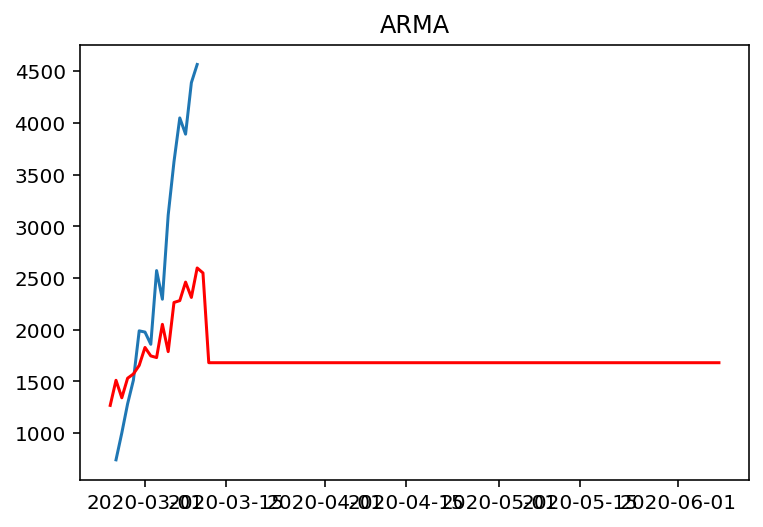

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


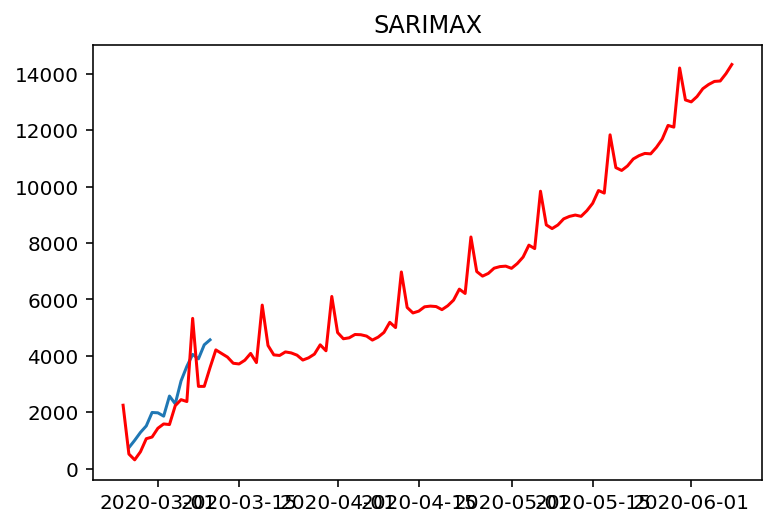

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


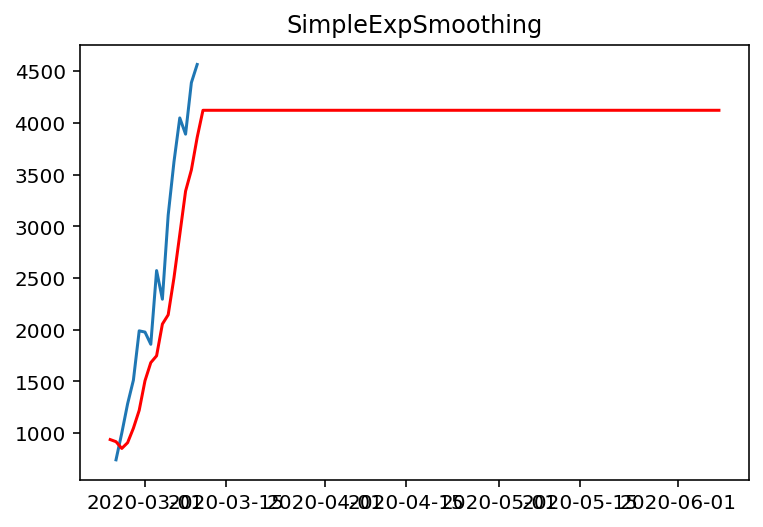

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


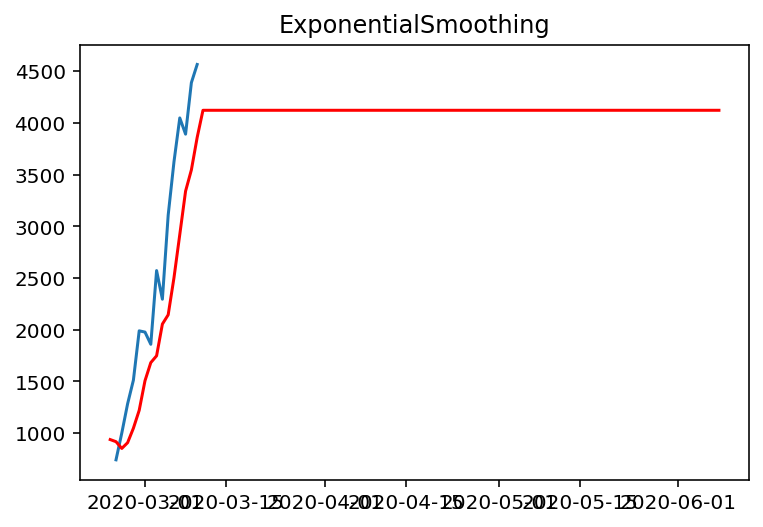

In [24]:
algo =[
    [AR(diff), 'AutoRegression'], 
    [ARMA(diff, order=(0, 1)), 'ARMA'], 
    [SARIMAX(diff, order=(1, 2, 3), seasonal_order=(1, 1, 1, 12)), 'SARIMAX'], 
#     [VAR(df), 'VAR']
#     [VARMAX(diff, order=(2, 1)), 'VARMAX'], 
    [SimpleExpSmoothing(diff), 'SimpleExpSmoothing'], 
    [ExponentialSmoothing(diff), 'ExponentialSmoothing']
]
for i in algo:
    model = i[0]
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)+90)
    predictions[predictions < 0] = 0
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.title(i[1])
    plt.show()

## predict on SARIMA(3)

In [25]:
import statsmodels.api as sm

In [26]:
model=sm.tsa.statespace.SARIMAX(endog=diff,order=(1,2,3),seasonal_order=(1,1,1,12))
results=model.fit()
predictions = results.predict(start=len(train)+len(test), end=len(train)+len(test)+365)
predictions[predictions < 0] = 0
print(results.summary())

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                 case   No. Observations:                   71
Model:             SARIMAX(1, 2, 3)x(1, 1, [1], 12)   Log Likelihood                -514.793
Date:                              Wed, 11 Mar 2020   AIC                           1043.585
Time:                                      15:29:47   BIC                           1057.886
Sample:                                  12-31-2019   HQIC                          1049.143
                                       - 03-10-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9967      1.393      0.716      0.474      -1.733       3.727
ma.L1         -2.47

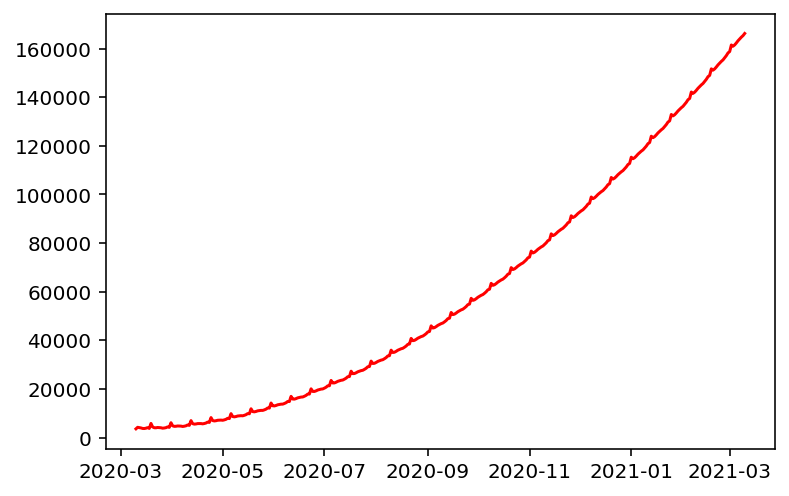

In [27]:
plt.plot(predictions, color='red')

In [28]:
predictions

2020-03-10      3581.661214
2020-03-11      4208.712287
2020-03-12      4080.873155
2020-03-13      3954.320692
2020-03-14      3735.115837
                  ...      
2021-03-06    163241.669788
2021-03-07    164006.329314
2021-03-08    164730.250568
2021-03-09    165359.604529
2021-03-10    166235.944653
Freq: D, Length: 366, dtype: float64

In [29]:
# predictions.to_csv('case_pred.csv')